In [3]:
import pandas as pd
import torch
import matplotlib.pyplot as plt
from transformers import T5Tokenizer, T5ForConditionalGeneration
import random 
from typing import List

tokenizer = T5Tokenizer.from_pretrained("google/flan-t5-xxl")

In [4]:
%load_ext autoreload
%autoreload 2

In [7]:
bd1 = pd.read_json("output/bigdsetp3.jsonl", orient='records', lines=True)
bd2 = pd.read_json("output/bigdsetp1.jsonl", orient='records', lines=True)
bd3 = pd.read_json("output/bigdsetp2.jsonl", orient='records', lines=True)
bd4 = pd.read_json("output/bigdsetp4.jsonl", orient='records', lines=True)
bd5 = pd.read_json("output/bigdsetp5.jsonl", orient='records', lines=True)

In [9]:
bdfull = pd.concat([bd1, bd2, bd3, bd4, bd5])

In [10]:
bdfull

,inp,hyps,scos,stats,ver,pref,prefix
0,Why are some people naturally talented with ma...,[Is there a brain mutation? No. But there are ...,"[0.6448739171, 0.783474803, 0.843218863, 0.780...","{'mean': [], 'stdev': [], 'entropy': [[2.536, ...",first,0.0,NaN
1,Why are some people naturally talented with ma...,[I met someone who could square or find the lo...,"[0.878369987, 0.7617390156, 0.7507990003, 0.91...","{'mean': [], 'stdev': [], 'entropy': [[0.0, 0....",best,NaN,80.0
2,"Why Comcast ""Xfinity"" ads are allowed to conti...","[Comcast's ""Xfinity"" ads claim they are the fa...","[0.9605834484, 0.9312849045, 0.9253003597, 0.8...","{'mean': [], 'stdev': [], 'entropy': [[1.704, ...",first,0.0,NaN
3,"Why Comcast ""Xfinity"" ads are allowed to conti...","[Comcast's ""Xfinity"" ads claim they are the fa...","[0.9487714767000001, 0.9587378502, 0.951922714...","{'mean': [], 'stdev': [], 'entropy': [[1.51900...",best,NaN,173.0
4,Why my computer was so brilliantly fast when I...,[The reason your computer runs so slowly after...,"[0.8392536044000001, 0.6798971295, 0.491327285...","{'mean': [], 'stdev': [], 'entropy': [[2.783, ...",first,0.0,NaN
...,...,...,...,...,...,...,...
3677,Why do people sometimes expand emails when typ...,[It is a very common practice to enter email a...,"[0.8973682523000001, 0.8814910650000001, 0.739...","{'mean': [], 'stdev': [], 'entropy': [[0.0, 0....",best,NaN,15.0
3678,Why cant we just draw blood to reduce blood pr...,[Low blood pressure is a medical emergency and...,"[0.8850297332, 0.6899237037, 0.877643764000000...","{'mean': [], 'stdev': [], 'entropy': [[2.787, ...",first,0.0,NaN
3679,Why cant we just draw blood to reduce blood pr...,[The blood pressure needs the blood to be pump...,"[0.487190485, 0.6126899123, 0.3531151414, 0.56...","{'mean': [], 'stdev': [], 'entropy': [[1.469, ...",best,NaN,17.0
3680,How do fingernails grow longer while being att...,[Nails grow by absorbing nutrients from the sk...,"[0.5571106672, 0.5775953531, 0.8585965633, 0.7...","{'mean': [], 'stdev': [], 'entropy': [[1.211, ...",first,0.0,NaN


In [11]:
def random_prefix_dataframe(df: pd.DataFrame) -> pd.DataFrame:
    new_rows = []

    for index, row in df.iterrows():
        input_str = row['inp']
        hyps = row['hyps']
        scos = row['scos']
        
        for hyp, sco in zip(hyps, scos):
            words = hyp.split(' ')
            prefix_length = random.randint(1, len(words))
            prefix = ' '.join(words[:prefix_length])

            new_row = {
                'inp': input_str,
                'hyp': prefix,
                'pflen':prefix_length,
                'sco': sco
            }
            new_rows.append(new_row)

    new_df = pd.DataFrame(new_rows)
    return new_df

In [21]:
import pandas as pd
from statistics import stdev

# Minimal matching prefix function
def common_prefix(strings):
    if not strings:
        return ""

    prefix = strings[0]
    for s in strings[1:]:
        while not s.startswith(prefix):
            prefix = prefix[:-1]
            if not prefix:
                return ""
    return prefix

def get_common_dset(df):

    # Split dataframes
    df_first = df[df['ver'] == 'first'].reset_index(drop=True)
    df_best = df[df['ver'] != 'first'].reset_index(drop=True)
    print(len(df_first))
    print(len(df_best))
    # Merge dataframes
    merged_df = pd.merge(df_first, df_best, on='inp', suffixes=('_first', '_best'))

    # Calculate minimal matching prefix, max, and mean
    merged_df['prefix'] = merged_df['hyps_best'].apply(common_prefix)
    merged_df['max_scos_first'] = merged_df['scos_first'].apply(max)
    merged_df['stdev_first'] = merged_df['scos_first'].apply(stdev)
    merged_df['mean_scos_first'] = merged_df['scos_first'].apply(lambda x: sum(x)/len(x))
    merged_df['max_scos_best'] = merged_df['scos_best'].apply(max)
    merged_df['stdev_best'] = merged_df['scos_best'].apply(stdev)
    merged_df['mean_scos_best'] = merged_df['scos_best'].apply(lambda x: sum(x)/len(x))

    # Create new dataframe with required columns
    result = merged_df[['inp', 'prefix', 'max_scos_first', 'mean_scos_first', 'max_scos_best', 'mean_scos_best', 'stdev_first', 'stdev_best']]
    return result


In [22]:
comdset = get_common_dset(bdfull)

10166
10166


In [28]:
comdset[comdset.stdev_best>0.05]

,inp,prefix,max_scos_first,mean_scos_first,max_scos_best,mean_scos_best,stdev_first,stdev_best
0,Why are some people naturally talented with ma...,I met someone who could square or find the log...,0.843219,0.763136,0.914019,0.826232,0.083927,0.082208
2,Why my computer was so brilliantly fast when I...,I have a hp pavilion dv7 laptop that was fine ...,0.839254,0.681214,0.475056,0.333133,0.143916,0.123601
3,How older films can be made into 3D (eg Titani...,3D conversion of,0.800477,0.648367,0.839810,0.785747,0.205055,0.059344
6,Is Africa as unstable as the media portrays it...,Is Africa as stable as the media portrays it t...,0.972558,0.864264,0.937715,0.861529,0.125334,0.094180
8,Why are rainbows shaped like arches/parabolasS...,Rainbows are a reflection of the sun's light h...,0.612037,0.526865,0.690617,0.564146,0.086839,0.091508
...,...,...,...,...,...,...,...,...
10157,How did the light bulb become an international...,"In the USA and much of Europe, it is often use...",0.863845,0.742447,0.832445,0.629819,0.133299,0.176068
10159,Difference between all-wheel drive and four-wh...,All-wheel drive is a form of,0.931151,0.900287,0.939959,0.795636,0.036753,0.155823
10160,Why did Teachers in the past focused so much o...,I believe it was because of the difficulty in ...,0.866305,0.647476,0.435417,0.355696,0.231694,0.054955
10163,Why do people sometimes expand emails when typ...,It is a very common practice to enter email ad...,0.780431,0.748663,0.897368,0.821019,0.040119,0.079962


In [29]:
comdset['sco'] = comdset.stdev_best

In [31]:
comdset.to_json("std_dataset.jsonl", lines=True, orient="records")

In [26]:
alldata = random_prefix_dataframe(bdfull)

In [30]:
alldata[alldata['sco']>0.85]

,inp,hyp,pflen,sco
4,Why are some people naturally talented with ma...,I met someone who could square or find the log...,30,0.878370
7,Why are some people naturally talented with ma...,I met,2,0.914019
8,"Why Comcast ""Xfinity"" ads are allowed to conti...","Comcast's ""Xfinity"" ads claim they are the fas...",96,0.960583
9,"Why Comcast ""Xfinity"" ads are allowed to conti...",Comcast has a right to market their ISP as the...,75,0.931285
10,"Why Comcast ""Xfinity"" ads are allowed to conti...","Comcast's ads claim to be ""Xfinity"" the fastes...",84,0.925300
...,...,...,...,...
64666,Why does orange juice with pulp have the same ...,Pulp-free orange,2,0.879468
64667,Why does orange juice with pulp have the same ...,Pulp-free juice is made,4,0.881085
64668,Why does orange juice with pulp have the same ...,Fiber content is determined by the proportion ...,30,0.855274
64669,Why does orange juice with pulp have the same ...,Fiber content is determined by the proportion ...,15,0.883795


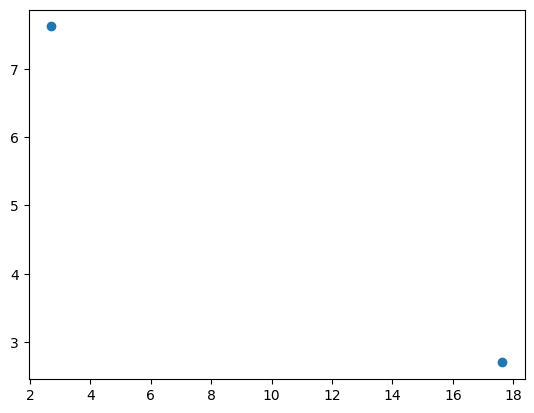

In [34]:
plt.scatter(x = [2.7, 17.63], y = [7.62, 2.7])

In [32]:
alldata.to_json("output/traingoodclassif.json", lines=True, orient="records")

In [27]:
bdfull.iloc[0]['hyps']

["Is there a brain mutation? No. But there are a lot of natural talents, some very good. Some skills can't be taught.",
 "Some people are talented in maths because they've learned it. It's like reading or playing an instrument, and you've innately developed the ability and a passion for it. The difference between these two cases is that one is related to your physical ability, the other is something learned. You can be born with a natural talent for music, but it takes a lot of practice. You can be born with a natural talent for maths, but it takes a lot of training and a passion. I can't answer your question about whether some people are naturally talented with maths. I can only say that it's a combination of both.",
 "I met someone who could square or find the log of any number you gave him, even if this is a trick, how did he do this? This is a tricky question, because he was able to do so without a calculator. How does he do this? That is where things get a little trickier, because

In [7]:
def mean(l):
    return sum(l)/len(l)

In [8]:
alluns = list(bdfull['inp'].unique())
omaxes = []
nmaxes = []
omeans = []
nmeans = []
for a in alluns:
    tmp = bdfull[bdfull['inp']==a].copy()
    oldval = tmp[tmp['ver']=='first'].iloc[0]
    newval = tmp[tmp['ver']!='first'].iloc[0]
    omaxes.append(max(oldval['scos']))
    nmaxes.append(max(newval['scos']))
    omeans.append(mean(oldval['scos']))
    nmeans.append(mean(newval['scos']))

In [41]:
diffs = [nmeans[i]-omeans[i] for i in range(len(omaxes))]

In [36]:
sum([d>0.1 for d in diffs])

273

(array([   3.,   11.,   60.,  256.,  897., 2829., 2929.,  913.,  151.,
          15.]),
 array([-0.55252679, -0.45797472, -0.36342264, -0.26887057, -0.1743185 ,
        -0.07976643,  0.01478565,  0.10933772,  0.20388979,  0.29844186,
         0.39299393]),
 <BarContainer object of 10 artists>)

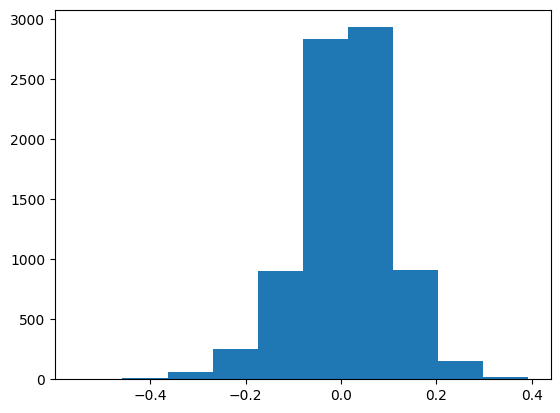

In [43]:
plt.hist(diffs)

In [5]:
adata = pd.read_json("improvedataset.jsonl", lines=True, orient='records')